In [7]:
from sklearn.model_selection import train_test_split
import numpy as np
from matrix_creation import polynomial_features, standard_scaler,scale_features_by_intercept_use
from main_methods import OLS_parameters,Ridge_parameters,gradient_descent_OLS,gradient_descent_ridge
from errors import MSE,R2


In [8]:
from plotting_exploration import plot_mse,plot_r2,explore_lambda,explore_polynomial_degree


In [9]:
# Runge's function

# parameters to explore
n_datapoints = 100 # changed and ran code with different values. Could have been implemented as a list and looped over, but regarded as not necessary.
standard_deviation = 0.1 # for noise, should we play around with this values as well in analysis?
p = 15 # polynomial degree
lambda_range = (-1,-5) # range of lambda values for np.log
lambda_n = 50 # number lambda values to explore
np.random.seed(250)  # ensure reproducibility

# generating data without noise
x = np.linspace(-1, 1, num=n_datapoints)
y = 1 / (1 + 25 * x**2)

# generating data with noise
x_noise = np.linspace(-1, 1, num=n_datapoints) + np.random.normal(0, standard_deviation, n_datapoints)
y_noise = 1 / (1 + 25 * x_noise**2)


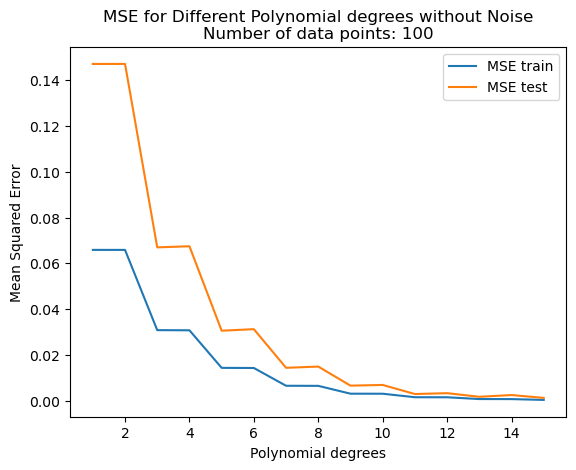

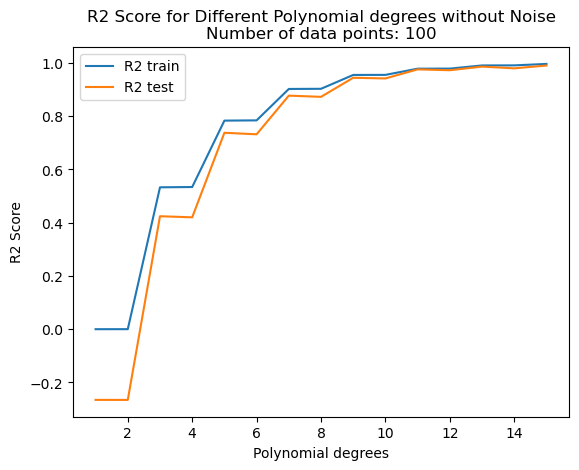

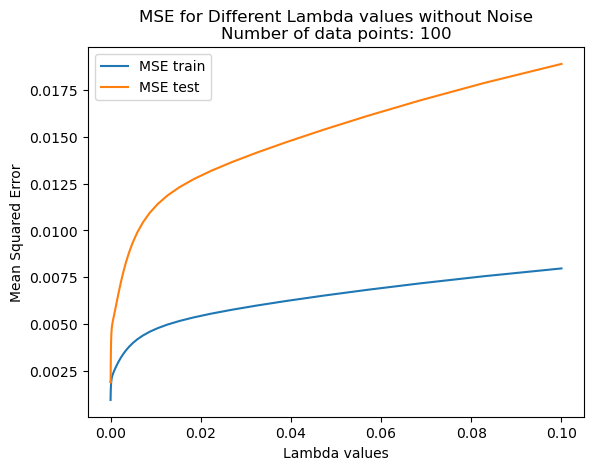

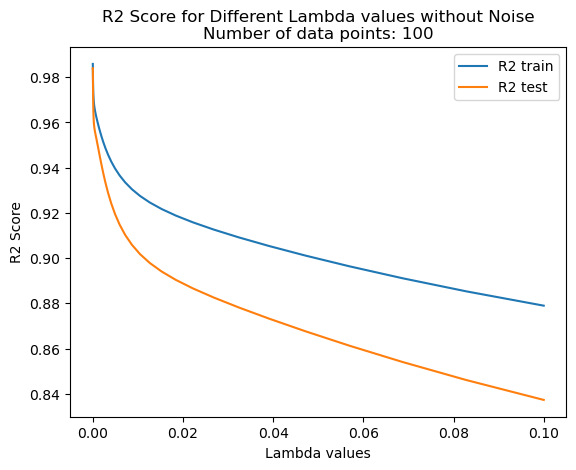

/home/jotje3041/thesis_2_electric_boogaloo/fystek-assignments/assignment1/code/matrix_creation.py:82: RuntimeWarning: invalid value encountered in divide
  X_train_scaled = (X_train - X_mean) / X_std
/home/jotje3041/thesis_2_electric_boogaloo/fystek-assignments/assignment1/code/matrix_creation.py:83: RuntimeWarning: invalid value encountered in divide
  X_test_scaled = (X_test - X_mean) / X_std


ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [10]:
# Runge's function analysis
##################################################

use_intercept = True # changed to variable to easily switch between True and False

# No noise
# creating design matrix with polynomial features: p
X = polynomial_features(x, p,intercept=use_intercept) # intercept=True gives intercept column = 0 in standard scaler if intercept is True, and hence division by 0. 

# test and train dataset, and scaling of X_train and X_test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train_scaled, X_test_scaled = scale_features_by_intercept_use(X_train, X_test, use_intercept)

# scaled data for features as input 
polynomial_degree, mse_train, mse_test, r2_train, r2_test = explore_polynomial_degree(X_train_scaled, X_test_scaled, y_train, y_test, p, use_intercept=use_intercept)
plot_mse(n_datapoints, polynomial_degree,"Polynomial degrees", mse_train, mse_test, noise=False)
plot_r2(n_datapoints, polynomial_degree,"Polynomial degrees", r2_train, r2_test, noise=False)

lambdas, mse_train_ridge, mse_test_ridge, r2_train_ridge, r2_test_ridge = explore_lambda(X_train_scaled, X_test_scaled, y_train, y_test,lambda_range,lambda_n)
plot_mse(n_datapoints, lambdas,"Lambda values", mse_train_ridge, mse_test_ridge, noise=False)
plot_r2(n_datapoints, lambdas,"Lambda values", r2_train_ridge, r2_test_ridge, noise=False)


##################################################

# With noise
# creating design matrix with polynomial features: p
X_noise = polynomial_features(x_noise, p,intercept=use_intercept) # intercept=True gives intercept column = 0 in standard scaler if intercept is True, and hence division by 0. Leaving intercept out since Ridge regression handles this

# test and train dataset, and scaling of X_train and X_test
X_train_noise, X_test_noise, y_train_noise, y_test_noise = train_test_split(X_noise, y_noise, test_size=0.2)
X_train_scaled_noise, X_test_scaled_noise = scale_features_by_intercept_use(X_train_noise, X_test_noise, use_intercept)
X_train_scaled_noise, X_test_scaled_noise = standard_scaler(X_train_noise, X_test_noise)

# scaled data for features as input 
polynomial_degree, mse_train, mse_test, r2_train, r2_test = explore_polynomial_degree(X_train_scaled_noise, X_test_scaled_noise, y_train_noise, y_test_noise, p, use_intercept=use_intercept)
plot_mse(n_datapoints, polynomial_degree, "polynomial degrees", mse_train, mse_test, noise=True)
plot_r2(n_datapoints, polynomial_degree, "polynomial degrees",r2_train, r2_test, noise=True)

lambdas, mse_train_ridge, mse_test_ridge, r2_train_ridge, r2_test_ridge = explore_lambda(X_train_scaled_noise, X_test_scaled_noise, y_train_noise, y_test_noise,lambda_range,lambda_n)
plot_mse(n_datapoints, lambdas,"Lambda values", mse_train_ridge, mse_test_ridge, noise=False)
plot_r2(n_datapoints, lambdas,"Lambda values", r2_train_ridge, r2_test_ridge, noise=False)


# About scaling - information for report

See "machine learning with Python and Scikit-learn - page 119-122" and https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#plot-all-scaling-standard-scaler-section.
From scikit documentation handling of outliers are important when scaling. Standard scaler is not robust to outliers, men our dataset is generated with some noise but no outliers. Standard scaler is hence ok to use, and mean and variance is mentioned. Write arguement for using standard scaler and not normaliazation.

From lecture notes: 

The StandardScaler function in Scikit-Learn ensures that for each feature/predictor we study the mean value is zero and the variance is one (every column in the design/feature matrix). This scaling has the drawback that it does not ensure that we have a particular maximum or minimum in our data set.

The Normalizer scales each data point such that the feature vector has a euclidean length of one. In other words, it projects a data point on the circle (or sphere in the case of higher dimensions) with a radius of 1. 
This means every data point is scaled by a different number (by the inverse of it’s length). This normalization is often used when only the direction (or angle) of the data matters, not the length of the feature vector.

The RobustScaler works similarly to the StandardScaler in that it ensures statistical properties for each feature that guarantee that they are on the same scale. 
However, the RobustScaler uses the median and quartiles, instead of mean and variance. This makes the RobustScaler ignore data points that are very different from the rest (like measurement errors). 
These odd data points are also called outliers, and might often lead to trouble for other scaling techniques.